# Context
Using a 10% sample (~100k users) of SF R2E Jan-Mar cohort's data, we leverage various meta-learners' predictions to validate the inference results.


# Methodology
#### Data Prep
1. Calculate propensity (in this case, propensity of Riders converting into Eaters)
2. Match Treatment users with Control users using propensity score
3. Validate whether Control and Treatment have similar pre-treatment behavior by measuring Standardized Mean Difference (SMD) of matching covariates
4. Re-calibrate propensity scores again
5. Validate matching again using SMD

#### Modeling
1. Iterate over meta learners (S/T/X/R Learner) using 2 models (Linear Regression and XGBoost), and predict GB lift for every learner-model pair.
2. Compare predictions by examining ATE (Average Treatment Effect, which is simply the mean of predictions) and distribution of treatment effect.

#### Sensitivity Analysis
We provided five methods for sensitivity analysis including (Placebb Treatment, Random Cause, Subset Data, Random Replace and Selection Bias).
This notebook will walkthrough how to use the combined function sensitivity_analysis() to compare different method and also how to use each individual method separately:

1. Placebo Treatment: Replacing treatment with a random variable
2. Irrelevant Additional Confounder: Adding a random common cause variable
3. Subset validation: Removing a random subset of the data
4. Selection Bias method with One Sided confounding function and Alignment confounding function
5. Random Replace: Random replace a covariate with an irrelevant variable

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install causalml

# !git clone https://github.com/uber/causalml.git
# !cd causalml
# !pip install -r causalml/requirements.txt
!git clone https://github.com/uber/causalml.git
!cd causalml

fatal: destination path 'causalml' already exists and is not an empty directory.


causalml  sample_data


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.model_selection import train_test_split
import warnings
import sys

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseRRegressor, BaseXRegressor
from causalml.match import NearestNeighborMatch, create_table_one, MatchOptimizer
from causalml.propensity import ElasticNetPropensityModel
from causalml.features import load_data
from causalml.features import LabelEncoder, OneHotEncoder
from causalml.metrics. sensitivity import Sensitivity

from uberml.data.data import check_data
import seaborn as sns
from matplotlib import rcParams

plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 6,8
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.max_columns = 2000
pd.options.display.max_rows = 2000
pd.options.display.max_seq_items = 2000
pd.options.display.float_format = '{:.4f}'.format

ModuleNotFoundError: ignored

# Analysis Setup

- Audience: Riders of SF
- Treatment Period: Jan - Mar 2018

In [ ]:
def plot_evaluation(y_true, y_prob):
    """Plot evaluation metircs

    Args:
        y_true (pandas.Series): label
        y_pred (pandas.Series): prediciton results

    """
    def plot_roc_curve(y, p):
        fpr, tpr, _ = roc_curve(y, p)
        roc_auc = roc_auc_score(y, p)
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='AUC = %0.1f)' % roc_auc)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

    def plot_pr_curve(y, p):
        precision, recall, _ = precision_recall_curve(y, p)

        plt.step(recall, precision, color='b', alpha=0.2, where='post')
        plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])

    print('AUC: {:.1f}%'.format(roc_auc_score(y_true, y_prob) * 100))
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc_score = auc(recall, precision)
    print('PR AUC: {:.1f}%'.format(pr_auc_score * 100))

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plot_roc_curve(y_true, y_prob)
    plt.subplot(1, 2, 2)
    plot_pr_curve(y_true, y_prob)

# Load data

In [ ]:
import pandas as pd
df = pd.read_csv('r2e_sf_20180101.csv.gz')
print(df.shape)

FileNotFoundError: ignored

In [ ]:
df['target'].value_counts()

False    96168
True      3832
Name: target, dtype: int64

In [ ]:
df_info = check_data(df)
df_info

,null percentage,dtype,unique values,min,mean,max
post_sum_gross_bookings,0.0000,float64,32373,0.0000,134.4562,7027.4500
post_sum_gross_bookings_rides,0.0000,float64,32109,0.0000,132.0292,7027.4500
post_trips_count,0.0000,int64,242,0,9.1790,1309
post_trips_count_rides,0.0000,int64,237,0,9.0994,1309
user_uuid,0.0000,object,100000,N/A,N/A,N/A
age_35_to_44,0.0000,float64,210,0.0000,20.4326,42.3000
age_45_to_54,0.0000,float64,199,0.0000,21.2861,36.6000
age_55_to_64,0.0000,float64,186,0.0000,18.0730,39.1000
age_65_to_74,0.0000,float64,164,0.0000,10.5664,26.3000
age_75_to_84,0.0000,float64,132,0.0000,6.3534,25.6000


# Define Features

In [ ]:
OUTCOME_COL = 'post_sum_gross_bookings'
TREATMENT_COL = 'target'
SCORE_COL = 'pihat'
GROUPBY_COL = 'billing_zip'
NAN_INT = -98765    # A random integer to impute missing values with

In [ ]:
PROPENSITY_FEATURES = ['age_35_to_44',
                       'age_45_to_54',
                       'age_55_to_64',
                       'age_65_to_74',
                       'age_75_to_84',
                       'education_bachelor_degree_or_higher',
                       'education_high_school_graduate',
                       'education_less_than_high_school',
                       'median_income',
                       'population',
                       'unemployment_rate',
                       'comparison_shopper_prob',
                       'is_fake_current_email',
                       'is_referral',
                       'is_uber_current_email',
                       'signup_device',
                       'signup_form',
                       'pct_commute_trips',
                       'pct_weekend_trips',
                       'recency_days',
                       'sum_gross_bookings',
                       'sum_incentives',
                       'surge_multiplier_avg',
                       'trips_within_time_period',
                       'days_since_ft']

MATCHING_COVARIATES = ['comparison_shopper_prob',
                       SCORE_COL,
                       'pct_commute_trips',
                       'pct_weekend_trips',
                       'recency_days',
                       'sum_gross_bookings',
                       'sum_incentives',
                       'surge_multiplier_avg',
                       'trips_within_time_period',
                       'days_since_ft']

INFERENCE_FEATURES = PROPENSITY_FEATURES + [SCORE_COL]

# Data PreProcessing

## Categorical Features

In [ ]:
ENCODING_COLS = [
'channel',
'signup_device',
'signup_form',
'trip_most_freq_prdct_name']

In [ ]:
# Label Encoding
threshold = int(0.001 * df.shape[0])
lbe = LabelEncoder(min_obs=threshold)
df[ENCODING_COLS] = lbe.fit_transform(df[ENCODING_COLS])

## Numerical Features

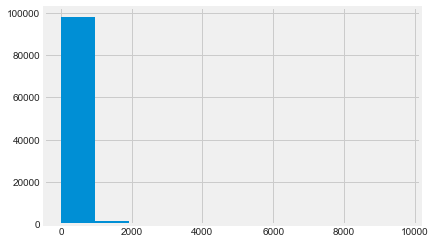

In [ ]:
df['sum_gross_bookings'].hist()

In [ ]:
# Log transform
df['sum_gross_bookings'] = np.log1p(df['sum_gross_bookings']).fillna(0)

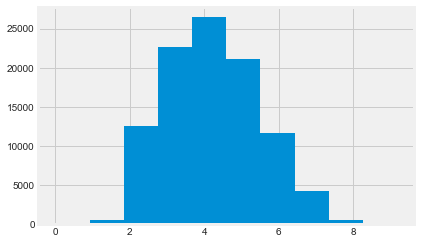

In [ ]:
df['sum_gross_bookings'].hist()

## Missing Values

In [ ]:
df_info.sort_values('null percentage', ascending=False).head(n=5)

,null percentage,dtype,unique values,min,mean,max
post_sum_gross_bookings,0.0000,float64,32373,0.0000,134.4562,7027.4500
sum_gross_bookings_bz,0.0000,float64,4596,0.0000,9.0034,9656.7400
median_income,0.0000,int64,713,0,85131.1665,223893
pct_commute_trips,0.0000,float64,2163,0.0000,0.2552,1.0000
pct_weekend_trips,0.0000,float64,1776,0.0000,0.3684,1.0000


In [ ]:
# drop users with missing values in following columns
cols_to_drop_users = [
                      'signup_form',
                      'days_since_signup']
relevant_cols = np.union1d(PROPENSITY_FEATURES, np.union1d(MATCHING_COVARIATES, INFERENCE_FEATURES))

In [ ]:
df[[c for c in relevant_cols if c in df]].isnull().sum()

age_35_to_44                           0
age_45_to_54                           0
age_55_to_64                           0
age_65_to_74                           0
age_75_to_84                           0
comparison_shopper_prob                0
days_since_ft                          0
education_bachelor_degree_or_higher    0
education_high_school_graduate         0
education_less_than_high_school        0
is_fake_current_email                  0
is_referral                            0
is_uber_current_email                  0
median_income                          0
pct_commute_trips                      0
pct_weekend_trips                      0
pihat                                  0
population                             0
recency_days                           0
signup_device                          0
signup_form                            0
sum_gross_bookings                     0
sum_incentives                         0
surge_multiplier_avg                   0
trips_within_tim

# Build Propensity Model

In [ ]:
params = {
          'objective': 'binary',
          'metric': 'auc',
          'learning_rate': 0.1,
          'num_leaves': 6,
          'bagging_freq': 1,
          'seed': 8,
          'verbose': 0,
          'num_threads': -1,
         }

PROPENSITY_FEATURES = [col for col in PROPENSITY_FEATURES if col in df.columns]

In [ ]:
X_trn, X_val, y_trn, y_val = train_test_split(df[PROPENSITY_FEATURES], df[TREATMENT_COL].values, test_size=0.2)

lgb_train = lgb.Dataset(X_trn, label=y_trn)
lgb_valid = lgb.Dataset(X_val, label=y_val)

clf = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                early_stopping_rounds=20,
                valid_sets=lgb_valid,
                verbose_eval=0)
n_best = clf.best_iteration
print('n_best', n_best)

n_best 82


In [ ]:
p_val = clf.predict(X_val)
print('Validation AUC={:.4f}'.format(roc_auc_score(y_val, p_val)))

Validation AUC=0.6780


In [ ]:
p_train = clf.predict(X_trn)
print('Train AUC={:.4f}'.format(roc_auc_score(y_trn, p_train)))

Train AUC=0.7114


In [ ]:
df['pihat']  = clf.predict(df[PROPENSITY_FEATURES])

In [ ]:
imp = pd.DataFrame({'feature': PROPENSITY_FEATURES,
                    'gain': clf.feature_importance(importance_type='gain')})
imp.loc[:, 'gain'] = imp.gain / imp.gain.sum()
imp = imp.sort_values('gain', ascending=False).set_index('feature')
imp = imp.reset_index()
imp.head(n=10)

,feature,gain
0,trips_within_time_period,0.3676
1,comparison_shopper_prob,0.1243
2,recency_days,0.0860
3,days_since_ft,0.0572
4,age_35_to_44,0.0330
5,pct_weekend_trips,0.0276
6,signup_device,0.0261
7,sum_gross_bookings,0.0259
8,surge_multiplier_avg,0.0232
9,age_45_to_54,0.0218


AUC: 67.8%
PR AUC: 7.8%


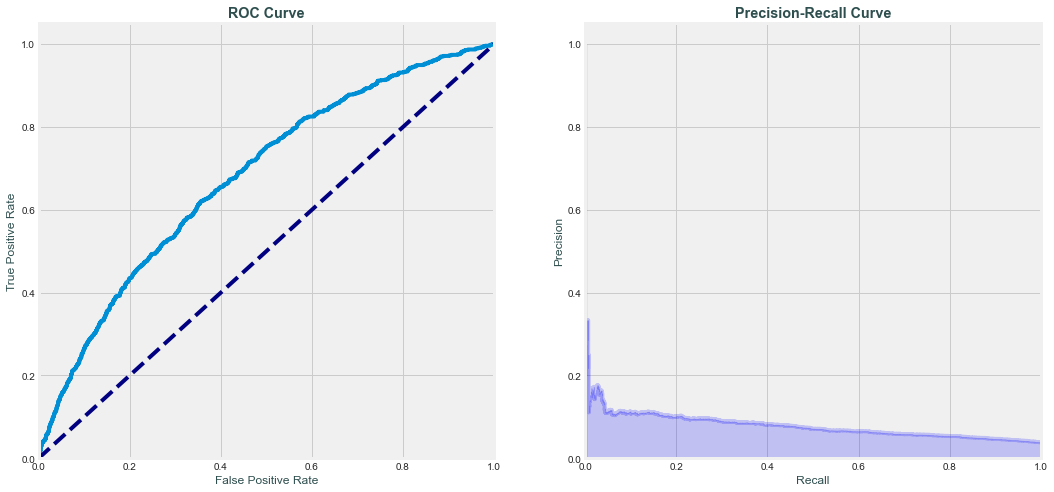

In [ ]:
plot_evaluation(y_val, p_val)

AUC: 71.1%
PR AUC: 12.1%


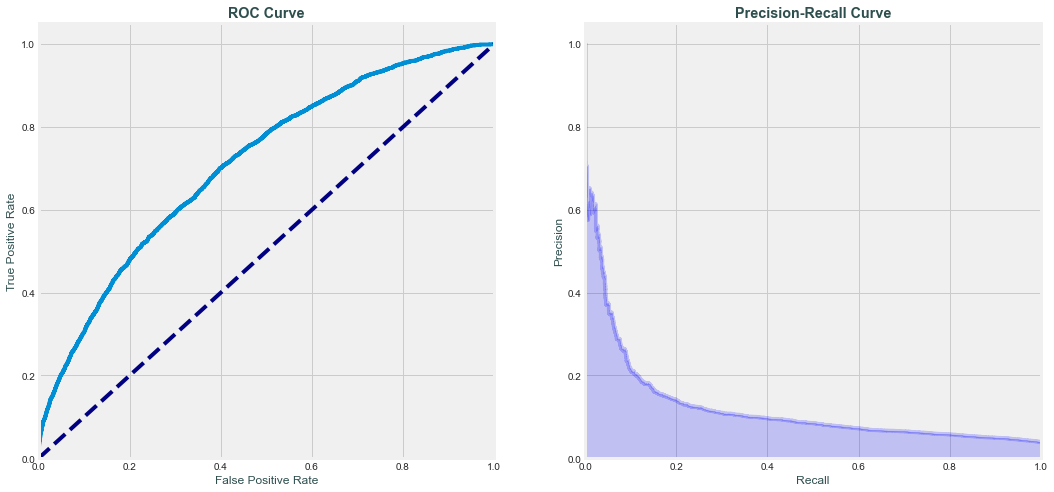

In [ ]:
plot_evaluation(y_trn, p_train)

# Propensity Score Matching

# New Section

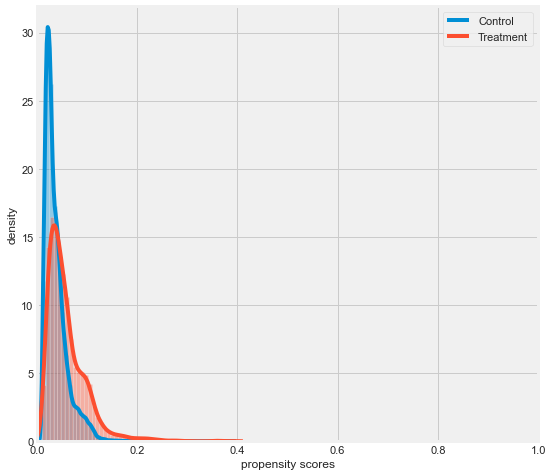

In [ ]:
# plot propensity score
rcParams['figure.figsize'] = 8,8
ax = sns.distplot(df[df[TREATMENT_COL] == 0]['pihat'])
sns.distplot(df[df[TREATMENT_COL] == 1]['pihat'])
ax.set_xlim(0, 1)
ax.set_xlabel("propensity scores")
ax.set_ylabel('density')
ax.legend(['Control', 'Treatment'])

In [ ]:
# before matching
create_table_one(df, treatment_col='target', features=MATCHING_COVARIATES)

,Control,Treatment,SMD
Variable,,,
n,96168,3832,
comparison_shopper_prob,0.26 (0.27),0.36 (0.29),0.3327
days_since_ft,684.11 (505.68),749.99 (538.00),0.1262
pct_commute_trips,0.25 (0.30),0.26 (0.25),0.0230
pct_weekend_trips,0.37 (0.35),0.37 (0.29),0.0080
pihat,0.04 (0.02),0.06 (0.04),0.6773
recency_days,29.02 (25.21),20.36 (21.06),-0.3727
sum_gross_bookings,4.20 (1.24),4.73 (1.34),0.4137
sum_incentives,-0.28 (1.68),-0.39 (1.94),-0.0601


In [ ]:
matcher = NearestNeighborMatch(caliper=0.01, replace=True)
df_matched = matcher.match(data=df, treatment_col='target', score_cols=['pihat'])

In [ ]:
# after matching
create_table_one(df_matched, treatment_col='target', features=MATCHING_COVARIATES)

,Control,Treatment,SMD
Variable,,,
n,3773,3773,
comparison_shopper_prob,0.37 (0.29),0.36 (0.29),-0.0482
days_since_ft,777.55 (535.15),755.21 (536.08),-0.0417
pct_commute_trips,0.26 (0.25),0.26 (0.25),-0.0014
pct_weekend_trips,0.37 (0.28),0.37 (0.29),0.0197
pihat,0.06 (0.03),0.06 (0.03),-0.0000
recency_days,18.96 (20.19),20.55 (21.11),0.0772
sum_gross_bookings,4.85 (1.34),4.72 (1.34),-0.0936
sum_incentives,-0.38 (1.53),-0.37 (1.72),0.0052


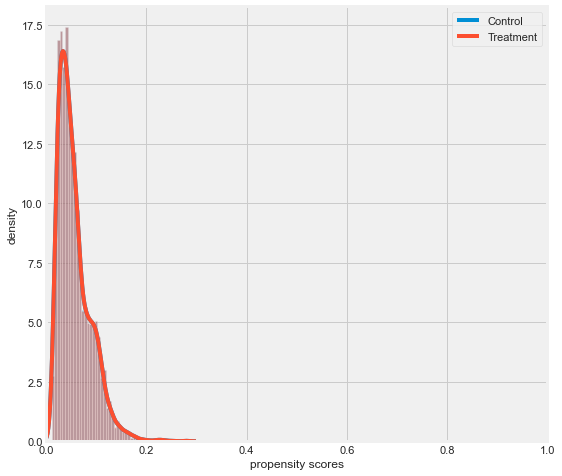

In [ ]:
# plot propensity score
ax = sns.distplot(df_matched[df_matched[TREATMENT_COL] == 0]['pihat'])
sns.distplot((df_matched[df_matched[TREATMENT_COL] == 1]['pihat']))
ax.set_xlim(0, 1)
ax.set_xlabel("propensity scores")
ax.set_ylabel('density')
ax.legend(['Control', 'Treatment'])

### Re-Calibrate propensity (`pihat_recal`) after matching

In [ ]:
p_model = ElasticNetPropensityModel()
ohe = OneHotEncoder(min_obs=df.shape[0] * 0.01)
X_cat = ohe.fit_transform(df_matched[ENCODING_COLS]).todense()
X = np.hstack([df_matched[PROPENSITY_FEATURES].values, X_cat])

df_matched['pihat_recal'] = p_model.fit_predict(X, df_matched['target'])

In [ ]:
create_table_one(df_matched, treatment_col='target', features=MATCHING_COVARIATES+['pihat_recal'])

,Control,Treatment,SMD
Variable,,,
n,3773,3773,
comparison_shopper_prob,0.37 (0.29),0.36 (0.29),-0.0482
days_since_ft,777.55 (535.15),755.21 (536.08),-0.0417
pct_commute_trips,0.26 (0.25),0.26 (0.25),-0.0014
pct_weekend_trips,0.37 (0.28),0.37 (0.29),0.0197
pihat,0.06 (0.03),0.06 (0.03),-0.0000
pihat_recal,0.50 (0.01),0.50 (0.01),0.0573
recency_days,18.96 (20.19),20.55 (21.11),0.0772
sum_gross_bookings,4.85 (1.34),4.72 (1.34),-0.0936


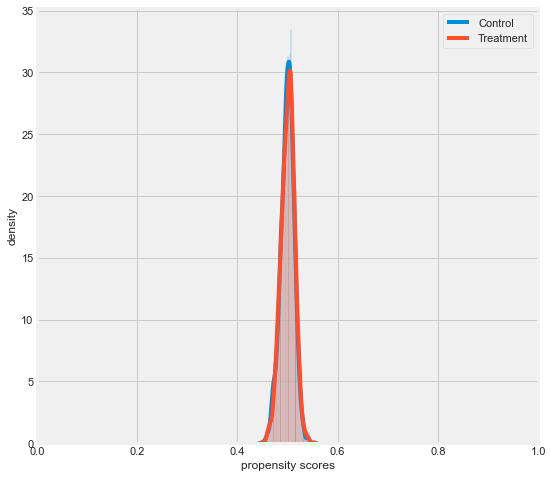

In [ ]:
# plot propensity score
ax = sns.distplot(df_matched[df_matched[TREATMENT_COL] == 0]['pihat_recal'])
sns.distplot((df_matched[df_matched[TREATMENT_COL] == 1]['pihat_recal']))
ax.set_xlim(0, 1)
ax.set_xlabel("propensity scores")
ax.set_ylabel('density')
ax.legend(['Control', 'Treatment'])

# Inference Analysis

In [ ]:
def prepare_inputs(df, p_col='pihat', w_col='target', y_col='post_sum_gross_bookings', inference_features=INFERENCE_FEATURES):
    X =df[INFERENCE_FEATURES].values
    p = df[p_col].values
    w = df[w_col].values
    df[y_col] = df[y_col].fillna(0)
    y = df[y_col].values

    return X, p ,w, y

In [ ]:
INFERENCE_FEATURES_LR =[col for col in INFERENCE_FEATURES if col not in ENCODING_COLS ]

In [ ]:
def run_learners(df, p_col='pihat', w_col='target', y_col='post_sum_gross_bookings', k=5):
    preds_dict = {}

    for base_learner,label_l in zip([BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor],['S','T','X','R']):
        for model,label_m in zip([LinearRegression, XGBRegressor],['LR', 'XGB']):
            if label_m !='LR':
                X, p, w, y = prepare_inputs(df, p_col, w_col, y_col)
            else:
                ohe = OneHotEncoder(min_obs=df.shape[0] * 0.01)
                X_cat = ohe.fit_transform(df[ENCODING_COLS]).todense()
                X = np.hstack([df[INFERENCE_FEATURES_LR].values, X_cat])
                p = df[p_col].values
                w = df[w_col].values
                df[y_col] = df[y_col].fillna(0)
                y = df[y_col].values

            if label_l == 'S':
                learner = base_learner(learner=model())
                ate, lb, ub = learner.estimate_ate(X=X,treatment=w,y=y,return_ci=True)
                preds_dict['{} Learner ({})'.format(label_l, label_m)] = np.ravel([ate, lb, ub])
            elif label_l == 'T':
                learner = base_learner(learner=model())
                ate, lb, ub = learner.estimate_ate(X=X,treatment=w,y=y)
                preds_dict['{} Learner ({})'.format(label_l, label_m)] = np.ravel([ate, lb, ub])
            elif label_l == 'X':
                learner = base_learner(learner=model())
                ate, lb, ub = learner.estimate_ate(X=X,p=p,treatment=w,y=y)
                preds_dict['{} Learner ({})'.format(label_l, label_m)] = np.ravel([ate, lb, ub])
            elif label_l == 'R':
                learner = base_learner(model(), n_fold=k)
                ate, lb, ub = learner.estimate_ate(X=X,p=p,treatment=w,y=y)
                preds_dict['{} Learner ({})'.format(label_l, label_m)] = np.ravel([ate, lb, ub])
    return preds_dict

In [ ]:
def get_ate_summary(df, preds_dict, w_col='target', y_col='post_sum_gross_bookings'):
    preds_df = pd.DataFrame(preds_dict).T
    preds_df.columns = ['ATE', 'Lower', 'Upper']
    post_treatment = df[df[w_col]==1][y_col].mean()
    preds_df['Baseline'] = post_treatment - preds_df['ATE']
    preds_df['Lift'] = preds_df['ATE'] / preds_df['Baseline']
    preds_df = preds_df.round(4)
    return preds_df.T

In [ ]:
# After Re-Calibrate
preds = run_learners(df_matched, y_col='post_sum_gross_bookings', p_col='pihat_recal')
get_ate_summary(df_matched, preds, y_col='post_sum_gross_bookings')

,S Learner (LR),S Learner (XGB),T Learner (LR),T Learner (XGB),X Learner (LR),X Learner (XGB),R Learner (LR),R Learner (XGB)
ATE,111.9957,102.1401,114.8478,116.3039,114.8478,116.7029,108.3691,115.7606
Lower,96.8326,89.0628,99.6770,103.5929,99.6770,104.1525,108.1919,115.5891
Upper,127.1588,115.2174,130.0186,129.0148,130.0186,129.2533,108.5463,115.9321
Baseline,222.0089,231.8645,219.1568,217.7007,219.1568,217.3017,225.6355,218.2440
Lift,0.5045,0.4405,0.5240,0.5342,0.5240,0.5371,0.4803,0.5304


[link text](https://)# Sensitivity Analysis

All Five methods (with One Sided confounding function and default alpha)

1.   List item
2.   List item



In [ ]:
# Calling the Base XLearner class and return the sensitivity analysis summary report
learner_x = BaseXRegressor(LinearRegression())
sens_x = Sensitivity(df=df_matched, inference_features=INFERENCE_FEATURES, p_col='pihat_recal',
                     treatment_col=TREATMENT_COL, outcome_col=OUTCOME_COL, learner=learner_x)
# Here for Selection Bias method will use default one-sided confounding function and alpha (quantile range of outcome values) input
sens_sumary_x = sens_x.sensitivity_analysis(methods=['Placebo Treatment',
                                                     'Random Cause',
                                                     'Subset Data',
                                                     'Random Replace',
                                                     'Selection Bias'], sample_size=0.9)

In [ ]:
# From the following results, refutation methods show our model is pretty robust;
# When alpah > 0, the treated group always has higher mean potential outcomes than the control; when  < 0, the control group is better off.
sens_sumary_x

,Method,ATE,New ATE,New ATE LB,New ATE UB
0,Placebo Treatment,122.1229,1.6599,-13.4635,16.7833
0,Random Cause,122.1229,122.1624,107.2750,137.0497
0,Subset Data(sample size @0.9),122.1229,124.9739,109.0742,140.8735
0,Random Replace,122.1229,122.0869,107.2040,136.9697
0,"Selection Bias (alpha@-165, with r-sqaure:0.03764",122.1229,287.1229,272.2356,302.0103
0,"Selection Bias (alpha@-129, with r-sqaure:0.02367",122.1229,251.1229,236.2356,266.0103
0,"Selection Bias (alpha@-92, with r-sqaure:0.01235",122.1229,214.1229,199.2356,229.0103
0,"Selection Bias (alpha@-55, with r-sqaure:0.00452",122.1229,177.1229,162.2356,192.0103
0,"Selection Bias (alpha@-18, with r-sqaure:0.00049",122.1229,140.1229,125.2356,155.0103
0,"Selection Bias (alpha@0, with r-sqaure:0.0",122.1229,122.1229,107.2356,137.0103
